### Import packages and libraries

In [30]:
! pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [125]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn import metrics, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler


import pickle
import matplotlib.pyplot as plt


import os
import warnings
warnings.filterwarnings('ignore')

#os.system('mkdir plot')
#os.system('mkdir model')
#os.system('mkdir data')

  # Data exploration

In [10]:
#dataset
#data = '/content/drive/MyDrive/ACME-HappinessSurvey2020.csv'
data = '/content/drive/MyDrive/Apziva/project2/data/term-deposit-marketing-2020.csv'
model = '/content/drive/MyDrive/Apziva/project2/model/'
plot = '/content/drive/MyDrive/Apziva/project2/plot/'


In [49]:
df = pd.read_csv(data)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Ordinal encoding

In [50]:
print('job:', df['job'].unique())
print('marital:', df['marital'].unique())
print('education:',df['education'].unique())
print('default:', df['default'].unique())
print('housing:', df['housing'].unique())
print('loan:', df['loan'].unique())
print('contact:', df['contact'].unique())
print('month:', df['month'].unique())

job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital: ['married' 'single' 'divorced']
education: ['tertiary' 'secondary' 'unknown' 'primary']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']


In [51]:
df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']] = df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']].apply(LabelEncoder().fit_transform)

In [102]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,0


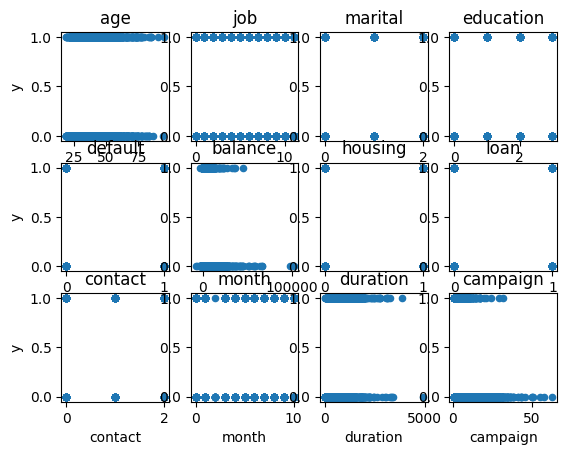

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=4)
df.plot(kind='scatter', x='age', y='y', ylabel='y', title='age', ax=axes[0,0])
df.plot(kind='scatter', x='job', y='y', ylabel='', title='job', ax=axes[0,1])
df.plot(kind='scatter', x='marital', y='y', ylabel='', title='marital', ax=axes[0,2])
df.plot(kind='scatter', x='education', y='y', ylabel='', title='education', ax=axes[0,3])
df.plot(kind='scatter', x='default', y='y', ylabel='y', title='default', ax=axes[1,0])
df.plot(kind='scatter', x='balance', y='y', ylabel='', title='balance', ax=axes[1,1])
df.plot(kind='scatter', x='housing', y='y', ylabel='', title='housing', ax=axes[1,2])
df.plot(kind='scatter', x='loan', y='y', ylabel='', title='loan', ax=axes[1,3])
df.plot(kind='scatter', x='contact', y='y', ylabel='y', title='contact', ax=axes[2,0])
#df.plot(kind='scatter', x='day', y='y', ylabel='', title='day', ax=axes[2,1])
df.plot(kind='scatter', x='month', y='y', ylabel='', title='month', ax=axes[2,1])
df.plot(kind='scatter', x='duration', y='y', ylabel='', title='duration', ax=axes[2,2])
df.plot(kind='scatter', x='campaign', y='y', ylabel='', title='campaign', ax=axes[2,3])

plt.savefig('plot/data_exploration.pdf', bbox_inches='tight')

##Data balacing with undersampling

In [58]:
## Check data balacing
print(len(df[df['y']==0]),len(df[df['y']==1]))

37104 2896


In [78]:
x=df[['age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign']].values
y=df.y.values

rus = RandomUnderSampler(random_state=42)

# fit predictor and target variable

x_rus, y_rus = rus.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_rus))

Original dataset shape Counter({0: 37104, 1: 2896})
Resample dataset shape Counter({0: 2896, 1: 2896})


In [111]:
print(df.balance.sort_values())

12909     -8019
15682     -6847
38736     -4057
7413      -3372
1896      -3313
          ...  
19420     64343
21192     66653
19785     66721
26227     98417
39989    102127
Name: balance, Length: 40000, dtype: int64


### Pre-processing training data

In [80]:
random_state=69
x_train, x_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size=0.2, random_state=random_state)

features=['age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', ]


## Running logistic regression

In [82]:
from math import log
log_clas = LogisticRegression()
# Fit the model on the trainng data.
log_clas.fit(x_train, y_train)
y_true, y_pred = y_test, log_clas.predict(x_test)
logacc = metrics.accuracy_score(y_true, y_pred)
logf1 = metrics.f1_score(y_true, y_pred)
print("Logistic regression accuracy: ",logacc)
print("Logistic regression f1 score: ",logf1)

Logistic regression accuracy:  0.8050043140638481
Logistic regression f1 score:  0.7937956204379562


##Running KNN

In [85]:
knn_clas = KNeighborsClassifier()
knn_clas.fit(x_train, y_train)
y_true, y_pred = y_test, knn_clas.predict(x_test)
knnacc = metrics.accuracy_score(y_true, y_pred)
knnf1 = metrics.f1_score(y_true, y_pred)
print("KNN accuracy: ",knnacc)
print("KNN f1 score: ",knnf1)

KNN accuracy:  0.7842968075927523
KNN f1 score:  0.7783687943262412


## Running SVM

In [86]:
svm_clas = SVC()
svm_clas.fit(x_train, y_train)
y_true, y_pred = y_test, svm_clas.predict(x_test)
svmacc = metrics.accuracy_score(y_true, y_pred)
svmf1 = metrics.f1_score(y_true, y_pred)
print("SVM accuracy: ",svmacc)
print("SVM f1 score: ",svmf1)

SVM accuracy:  0.7963761863675582
SVM f1 score:  0.7814814814814816


#Running Naive Bayes

In [114]:
nb_clas = GaussianNB()
nb_clas.fit(x_train, y_train)
y_true, y_pred = y_test, nb_clas.predict(x_test)
nbacc = metrics.accuracy_score(y_true, y_pred)
nbf1 = metrics.f1_score(y_true, y_pred)
print("NB accuracy: ",nbacc)
print("NB f1 score: ",nbf1)

NB accuracy:  0.7799827437446074
NB f1 score:  0.7776809067131648


##Running Decision tree

In [87]:
tree_clas = DecisionTreeClassifier(random_state=random_state)
tree_clas.fit(x_train, y_train)
y_true, y_pred = y_test, tree_clas.predict(x_test)
treeacc = metrics.accuracy_score(y_true, y_pred)
treef1 = metrics.f1_score(y_true, y_pred)
print("Decision tree accuracy: ",treeacc)
print("Decision tree f1 score: ",treef1)

Decision tree accuracy:  0.813632441760138
Decision tree f1 score:  0.8085106382978724


##Running random forest

In [89]:
rfc_clas = RandomForestClassifier(random_state=random_state)
rfc_clas.fit(x_train, y_train)
y_true, y_pred = y_test, rfc_clas.predict(x_test)
rfacc = metrics.accuracy_score(y_true, y_pred)
rff1 = metrics.f1_score(y_true, y_pred)
print("Random forest accuracy: ",rfacc)
print("Random forest f1 score: ",rff1)

Random forest accuracy:  0.8645383951682485
Random forest f1 score:  0.8640692640692641


##Plotting feature importance

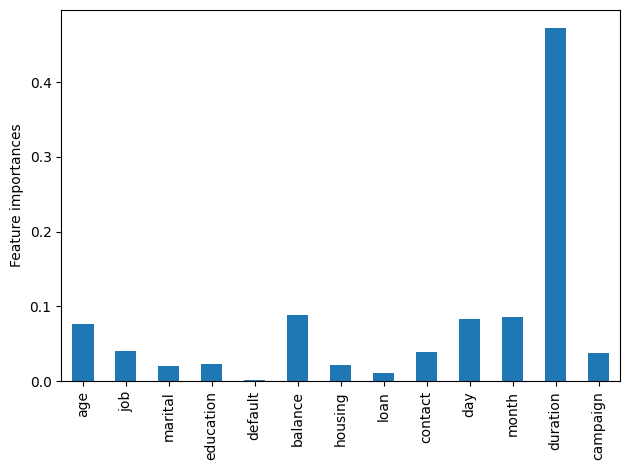

In [117]:
importances = rfc_clas.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_ylabel("Feature importances")
fig.tight_layout()
plt.savefig(plot+'feature_importance.pdf', bbox_inches='tight')
#for i in range(len(features)):
#  print(features[i],importances[i])

#Rnuuning AdaBoost

In [95]:
ada_clas = AdaBoostClassifier(random_state=random_state)
ada_clas.fit(x_train, y_train)
y_true, y_pred = y_test, ada_clas.predict(x_test)
adaacc = metrics.accuracy_score(y_true, y_pred)
adaf1 = metrics.f1_score(y_true, y_pred)
print("AdaBoost accuracy: ",adaacc)
print("AdaBoost f1 score: ",adaf1)

AdaBoost accuracy:  0.8524590163934426
AdaBoost f1 score:  0.8498683055311677


##Running XGBoost

In [92]:
xgb_clas = XGBClassifier(random_state=random_state)
xgb_clas.fit(x_train, y_train)
y_true, y_pred = y_test, xgb_clas.predict(x_test)
xgacc = metrics.accuracy_score(y_true, y_pred)
xgf1 = metrics.f1_score(y_true, y_pred)
print("XGBoost accuracy: ", xgacc)
print("XGBoost f1 score: ", xgf1)

XGBoost accuracy:  0.8714408973252804
XGBoost f1 score:  0.8727583262169086


#Cross-validation

In [132]:
scores = cross_val_score(xgb_clas, x_train, y_train, cv=5, scoring='f1')
scores.mean()

0.8784658518440264

#Grid search

In [122]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb_cv = GridSearchCV(estimator=xgb_clas, param_grid=params, cv=5)
xgb_cv.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=69, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]})

In [133]:
xgb_cv.best_score_

0.8804282841838672

In [135]:
xgb_cv.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=69, ...)

##Saving model

In [136]:
with open(model+"xgb_cv_model.pkl", 'wb') as f:
            pickle.dump(
                xgb_cv.best_estimator_,
#                xgb_clas,
                f,
                pickle.HIGHEST_PROTOCOL)